In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

IMG_SIZE = (512, 512)
MODEL_FILENAME = 'edge_classifier.keras'

# Heuristic to highlight edge discontinuity
def highlight_defect(img_gray):
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 10 < area < 500:  # filter small noise and big objects
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            if 5 < radius < 30:  # focus on small irregularities
                center = (int(x), int(y))
                radius = int(radius)
                cv2.circle(output, center, radius, (255, 0, 0), 2)  # red circle
    return output

# Predict and visualize
def predict_images_from_folder(folder='inference_images'):
    model = load_model(MODEL_FILENAME)
    for file in sorted(os.listdir(folder)):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            fpath = os.path.join(folder, file)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, IMG_SIZE)
            edges = cv2.Canny(img_resized, 50, 150)
            stacked = np.stack((img_resized, edges), axis=-1).astype(np.float32) / 255.0
            input_tensor = np.expand_dims(stacked, axis=0)
            pred = model.predict(input_tensor, verbose=0)[0][0]
            label = "Defective" if pred > 0.5 else "Normal"
            confidence = float(pred)

            if label == "Defective":
                output_img = highlight_defect(img_resized)
            else:
                output_img = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

            plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
            plt.title(f"{file} ➜ {label} ({confidence:.2f})")
            plt.axis('off')
            plt.show()

# === Main Trainer ===
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === CONFIG ===
DEFECTIVE_FOLDER = 'Defective'
NORMAL_FOLDER = 'Normal'

# === Load and Preprocess Images ===
def load_images(folder_path, label):
    images = []
    labels = []
    for ext in ('*.png', '*.jpg', '*.jpeg', '*.bmp'):
        for file in glob(os.path.join(folder_path, ext)):
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            edges = cv2.Canny(img, 50, 150)
            stacked = np.stack((img, edges), axis=-1).astype(np.float32) / 255.0
            images.append(stacked)
            labels.append(label)
    return np.array(images), np.array(labels)

# === Prepare Dataset ===
def prepare_dataset():
    defective_imgs, defective_labels = load_images(DEFECTIVE_FOLDER, 1)
    normal_imgs, normal_labels = load_images(NORMAL_FOLDER, 0)
    X = np.concatenate([defective_imgs, normal_imgs], axis=0)
    y = np.concatenate([defective_labels, normal_labels], axis=0)
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === Build a Lightweight CNN ===
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === Train Model with EarlyStopping ===
def train():
    X_train, X_test, y_train, y_test = prepare_dataset()
    model = build_model(X_train.shape[1:])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=50,
              validation_data=(X_test, y_test),
              batch_size=16,
              callbacks=[early_stop])

    model.save(MODEL_FILENAME)
    print("Model saved as", MODEL_FILENAME)

if __name__ == '__main__':
    train()

2025-04-07 10:27:27.548407: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 10:27:27.552147: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 10:27:27.560630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744046847.573939 3085559 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744046847.577881 3085559 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744046847.589692 3085559 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7455 - loss: 0.4204 - val_accuracy: 1.0000 - val_loss: 0.0257
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 8.4002e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 5.4735e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 4.3427e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 3.7159e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.

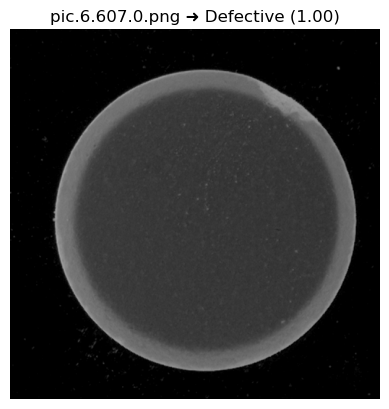

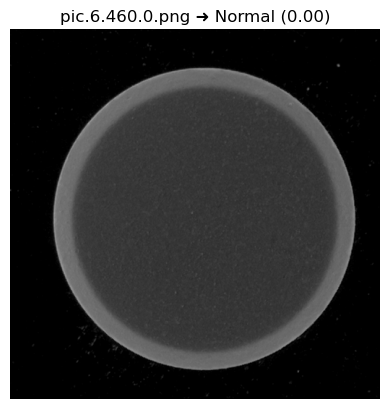

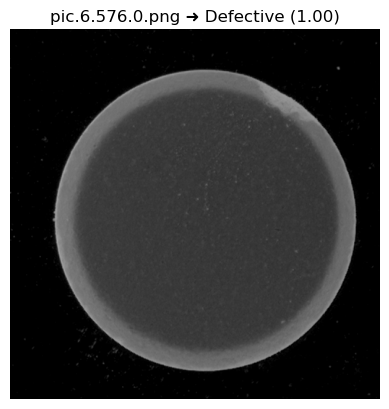

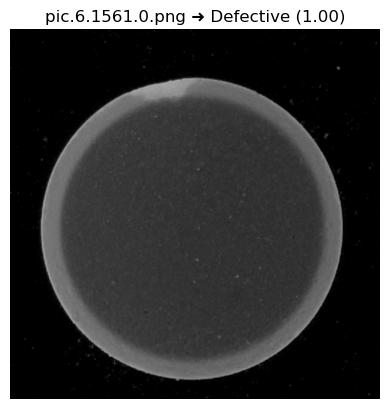

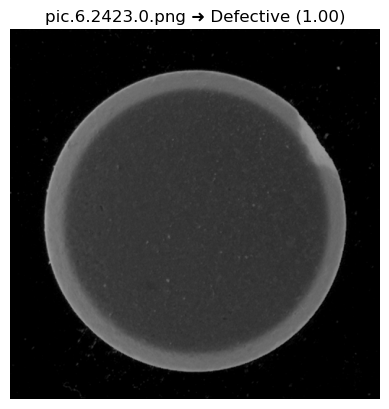

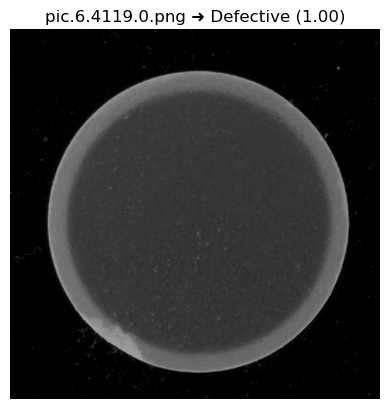

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tkinter import Tk, Button, Label, filedialog
from PIL import Image, ImageTk

IMG_SIZE = (512, 512)
MODEL_FILENAME = 'edge_classifier.keras'

# Function to mark defects on edges
def mark_defects_on_edges(img):
    img = cv2.resize(img, (512, 512))
    output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    _, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pill_mask = np.zeros_like(img)

    if len(contours) == 0:
        return output

    pill_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(pill_mask, [pill_contour], -1, 255, thickness=cv2.FILLED)

    masked = cv2.bitwise_and(img, img, mask=pill_mask)
    edges = cv2.Canny(masked, 40, 100)

    defect_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in defect_contours:
        area = cv2.contourArea(cnt)
        if area < 20 or area > 1000:
            continue
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        if cv2.pointPolygonTest(pill_contour, center, False) >= 0:
            cv2.circle(output, center, int(radius + 6), (0, 0, 255), 2)

    return output

# GUI-based upload and prediction
class DefectCheckerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Defect Checker")
        self.model = load_model(MODEL_FILENAME)

        self.upload_btn = Button(root, text="Upload Images", command=self.upload_images)
        self.upload_btn.pack(pady=10)

        self.result_label = Label(root, text="Select images to classify", font=("Arial", 12))
        self.result_label.pack()

    def upload_images(self):
        file_paths = filedialog.askopenfilenames(title="Select Images", filetypes=[("Image Files", "*.png *.jpg *.jpeg")])

        if not file_paths:
            self.result_label.config(text="No images selected.")
            return

        for fpath in file_paths:
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, IMG_SIZE)
            edges = cv2.Canny(img_resized, 50, 150)
            stacked = np.stack((img_resized, edges), axis=-1).astype(np.float32) / 255.0
            input_tensor = np.expand_dims(stacked, axis=0)
            pred = self.model.predict(input_tensor, verbose=0)[0][0]
            label = "Defective" if pred > 0.5 else "Normal"
            confidence = float(pred)

            if label == "Defective":
                output_img = mark_defects_on_edges(img_resized)
            else:
                output_img = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

            # Convert BGR to RGB and show in matplotlib
            plt.imshow(output_img[..., ::-1])
            plt.title(f"{os.path.basename(fpath)} ➜ {label} ({confidence:.2f})")
            plt.axis('off')
            plt.show()

# Launch the app
if __name__ == '__main__':
    root = Tk()
    app = DefectCheckerApp(root)
    root.mainloop()